# **WHATSAPP CHAT ANALYZER**

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#extraction">Data Extraction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>



<a id='intro'></a>
## Introduction
    
WhatsApp has become one of the most trendy social media platform. WhatsApp Chat Analyzer means is a platform that tracks our conversation and analyses group activities and how much time we
are spending  on WhatsApp. 


<a id='extraction'></a>
## Data Extraction

I used different python libraries to extract useful information from raw whatsapp data data

#### Import Required Libraries

In [1]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
from seaborn import * 
import seaborn as sns 
%matplotlib inline 
from datetime import * 
import datetime as dt 
from matplotlib.ticker import MaxNLocator 
import emoji
# from heatmap import heatmap 
from wordcloud import WordCloud , STOPWORDS ,ImageColorGenerator 
# from nltk import * 
from plotly import express as px
import datetime
from datetime import datetime
import textwrap


import os 
import re
import warnings 
warnings.filterwarnings('ignore')

Extract date and time

In [2]:
def extractDateAndTime(s):
    pattern = '^([0-9]+)(/)([0-9]+)(/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False


Extract username and author

In [3]:
def findAuthor(s): 
    patterns = ['([w]+):', # First Name 
                '([w]+[s]+[w]+):', # First Name + Last Name 
                '([w]+[s]+[w]+[s]+[w]+):', # First Name + Middle Name + Last Name 
                '([+]d{2} d{5} d{5}):', # Mobile Number (India no.) 
                '([+]d{2} d{3} d{3} d{4}):', # Mobile Number (US no.) 
                '([+]d{3} d{3} d{6}):', # Mobile Number (Kenya no.) 
                '([w]+)[u263a - U0001f999]+:', # Name and Emoji 
                ]
    
    pattern = '^ (([w]+):) | (([w]+[s]+[w]+):) | (([w]+[s]+[w]+[s]+[w]+):) | (([+]d{2} d{5} d{5}):) | (([+]d{2} d{3} d{3} d{4})) | (([+]d{3} d{3} d{6}):) | (([w]+)[u263a - U0001f999]+:)'
                
     
    # pattern = '^' + ' | '.join(patterns) 
    result = re.match(pattern, s) 
    if result: 
        return True 
    return False 

In [4]:
def getDataPoint(line): 
    splitLine = line.split(' - ') 
    dateTime = splitLine[0] 
    date, time = dateTime.split(',') 
    message = ' '.join(splitLine[1:]) 
    splitMessage = message.split(': ') 
    authorInfo = splitMessage[0] 
    message = ' '.join(splitMessage[1:])
    return date, time, authorInfo, message

s = '3/22/22, 11:49 PM - Millionaires Mind: Give Baba to campaign with.'
getDataPoint(s)


('3/22/22', ' 11:49 PM', 'Millionaires Mind', 'Give Baba to campaign with.')

Creating dataframe

In [5]:
parsedData = []
with open('Data\WhatsApp Chat with Voice of the Youth (VOY).txt', 'r' , encoding="utf8") as f:
    f.readline() # Skip first line
    messageBuffer = [] 
    date, time, authorInfo = None, None, None 
    while True: 
        line = f.readline() 
        if not line: 
            break 
        line = line.strip() 
        if extractDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, authorInfo, ' '.join(messageBuffer)]) 
                messageBuffer.clear() 
                date, time, authorInfo, message = getDataPoint(line)
                messageBuffer.append(message) 
        else: 
            messageBuffer.append(line) 
df = pd.DataFrame(parsedData, columns=['Date','Time', 'AuthorInfo', 'Message']) # Initialising a pandas Dataframe. ### changing datatype of "Date" column.
df["Date"] = pd.to_datetime(df["Date"])


In [6]:
df["Message"]= df["Message"].str.pad(3, side ='both')
df["AuthorInfo"]= df["AuthorInfo"].str.pad(0, side ='left')
df.tail()


,Date,Time,AuthorInfo,Message
935,2022-09-15,1:58 PM,Toko Tai 💫,<Media omitted>
936,2022-09-16,4:34 PM,+254 710 835708,"Anyone, Mombasa to kismu ni how much by bus"
937,2022-09-16,4:49 PM,+254 704 932171,2500 Ena Coach
938,2022-09-16,5:53 PM,Ochanda,<Media omitted>
939,2022-09-16,6:14 PM,+254 710 835708,Smart


Save the xtracted dataframe

In [7]:
df.to_excel('Data\extractedData.xlsx', index=False)

<a id='wrangling'></a>
## Data Wrangling

The data to be cleansed is stored as `extractedData.csv`. 

#### Data Understanding

To understand this data, I seek to answer the following questions:
    
> - How many active participants are in the group?

> - How many texts and media have been sent to the group?

> - What are the commonly used words in the group chat.

> - What are the emotions attached to every user?

> - What are the trends in chatting in the group?

#### Load Data

In [8]:
data = pd.read_excel('Data\extractedData.xlsx')
data.head()

,Date,Time,AuthorInfo,Message
0,NaT,NaN,NaN,🥳🥳🥳...
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        939 non-null    datetime64[ns]
 1   Time        939 non-null    object        
 2   AuthorInfo  939 non-null    object        
 3   Message     940 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 29.5+ KB


In [10]:
data.describe()

,Date,Time,AuthorInfo,Message
count,939,939,939,940
unique,119,589,88,728
top,2022-08-16 00:00:00,10:35 PM,+254 704 932171,<Media omitted>
freq,65,7,86,131
first,2022-03-23 00:00:00,NaN,NaN,NaN
last,2022-09-16 00:00:00,NaN,NaN,NaN


**Assessing Data**

- `Author Info` contains both names and contact numbers.
- `Message` column contains links, media, emojis and invalid numbers (0).
- `AuthorInfo` column not in proper format.
- One missing value

**Cleansing Data**

In [11]:
data_clean = data.copy()

#### Dropping Missing and Incorrect values

In [12]:
data_clean = data_clean.loc[~((data_clean['AuthorInfo'].isnull()==True) & (data_clean['Time'].isnull()==True)),:]
data_clean.head()

,Date,Time,AuthorInfo,Message
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????


In [13]:
data_clean[data_clean['Message'] == '']

,Date,Time,AuthorInfo,Message


In [14]:
data_clean.shape

(939, 4)

In [15]:
data_clean =data_clean[~data_clean['AuthorInfo'].str.contains('left|joined|added|changed')]

# count = 0
# for s in data_clean.AuthorInfo:
#     if len(s.split(' ')) > 6:
#        data_clean = data_clean.drop(data_clean.index[count])
#     elif 'left' in s:
#         data_clean = data_clean.drop(data_clean.index[count])
#     elif 'joined' in s:
#         data_clean = data_clean.drop(data_clean.index[count])
#     elif 'changed' in s:
#         data_clean = data_clean.drop(data_clean.index[count])
#     count += 1

    

In [16]:
data.Message.iloc[10:20]


10    Am giving out an opportunity For everyone here...
11                                      <Media omitted>
12                                      <Media omitted>
13               No payment To join You only need a VPN
14        I will be offering free classes And tutorials
15                                                     
16                                      <Media omitted>
17    Congratulations *Vincent Nyakwach* for being e...
18                                            Kabisaaaa
19                      Congratulations @254718520715 🥳
Name: Message, dtype: object

Drop the incorrect values

In [17]:
data_clean = data_clean[~(data_clean['Message'] == '')]

## Feature Engineering

#### Extract Phone Number

In [18]:
data_clean.columns

Index(['Date', 'Time', 'AuthorInfo', 'Message'], dtype='object')

In [19]:
data_clean.head(10)

,Date,Time,AuthorInfo,Message
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????
6,2022-03-23,11:28 PM,Toko Tai 💫,I have with zero history Hawakuwai Nipa kazi😂
7,2022-03-23,11:29 PM,Njogu Wa Kahiu,Ukiwezaa Pataa mtuu
8,2022-03-23,11:23 PM,+254 758 323013,Haven't gotten this
9,2022-03-23,11:25 PM,+254 758 323013,Whueeh😅
10,2022-03-23,11:56 PM,Toko Tai 💫,Am giving out an opportunity For everyone here...


In [20]:
data_clean['PhoneNumber'] = 0
data_clean['Name'] = 0
count = 0
for x in data_clean.AuthorInfo:
    if re.findall(r'\d+', x) :
        data_clean['PhoneNumber'].iloc[count] = x
        # print('{} - '.format(count) + x)
    else:
        data_clean['Name'].iloc[count] = x
        # print('{} - Match not found'.format(count))
    count += 1

In [21]:
data_clean.head()

,Date,Time,AuthorInfo,Message,PhoneNumber,Name
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...,0,Njogu Wa Kahiu
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...,0,Toko Tai 💫
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...,0,Toko Tai 💫
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...,0,Toko Tai 💫
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????,0,Njogu Wa Kahiu


#### Media Extraction

In [22]:
# data_clean['Media'] = np.where(data_clean['Message'] == '<Media omitted>',1 ,0)

MEDIAPATTERN = r'<Media omitted>'
data_clean['Media'] = data_clean.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len() 

In [23]:
# count = 0
# for s in data_clean.Message:
#     if '<Media omitted>' in s:
#         data_clean['Media'].iloc[count] = 1
#     else:
#         data_clean['Media'].iloc[count] = 0
#     count += 1

In [24]:
data_clean.head()

,Date,Time,AuthorInfo,Message,PhoneNumber,Name,Media
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...,0,Njogu Wa Kahiu,0
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...,0,Toko Tai 💫,0
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...,0,Toko Tai 💫,0
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...,0,Toko Tai 💫,0
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????,0,Njogu Wa Kahiu,0


#### Extract Links

In [25]:
data_clean['Message'].iloc[12:20]

13               No payment To join You only need a VPN
14        I will be offering free classes And tutorials
16                                      <Media omitted>
17    Congratulations *Vincent Nyakwach* for being e...
18                                            Kabisaaaa
19                      Congratulations @254718520715 🥳
20                      @254718520715  for The Position
21                 Congratulations @254718520715   ❤️❤️
Name: Message, dtype: object

In [26]:
data_clean['Link'] = np.where(data_clean['Message'].str.contains('http:|https:|.com |.org'),1 ,0 )
# URLPATTERN = r'(https?://S+)'
# data_clean['Link'] = data_clean.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() 

In [27]:
data_clean.head()

,Date,Time,AuthorInfo,Message,PhoneNumber,Name,Media,Link
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...,0,Njogu Wa Kahiu,0,0
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...,0,Toko Tai 💫,0,0
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...,0,Toko Tai 💫,0,0
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...,0,Toko Tai 💫,0,0
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????,0,Njogu Wa Kahiu,0,0


In [28]:
data_clean['Message'] = data_clean['Message'].apply(lambda s: s.replace('\n', '  '))

Wrap Message text

In [29]:
# data_clean['Message'] = data_clean['Message'].apply(lambda x : textwrap.fill(x, 20, drop_whitespace=True))

In [30]:
data_clean.head()

,Date,Time,AuthorInfo,Message,PhoneNumber,Name,Media,Link
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...,0,Njogu Wa Kahiu,0,0
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...,0,Toko Tai 💫,0,0
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...,0,Toko Tai 💫,0,0
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...,0,Toko Tai 💫,0,0
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????,0,Njogu Wa Kahiu,0,0


Align messages to the right and right

In [31]:
# data_clean["Message"]= data_clean["Message"].str.pad(5, side ='left')
# data_clean["AuthorInfo"]= data_clean["AuthorInfo"].str.pad(15, side ='both')
# data_clean["PhoneNumber"]= data_clean["PhoneNumber"].str.pad(15, side ='both')
# data_clean["Name"]= data_clean["Name"].str.pad(15, side ='both')
# data_clean["Media"]= data_clean["PhoneNumber"].str.pad(15, side ='both')
data_clean.fillna(0)

,Date,Time,AuthorInfo,Message,PhoneNumber,Name,Media,Link
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,Hello Guys Who Has An Upwork Account That Has ...,0,Njogu Wa Kahiu,0,0
2,2022-03-23,11:22 PM,Toko Tai 💫,Who has a diploma certificate Or a degree cert...,0,Toko Tai 💫,0,0
3,2022-03-23,11:24 PM,Toko Tai 💫,Like I want to use Someone's degree /diploma c...,0,Toko Tai 💫,0,0
4,2022-03-23,11:24 PM,Toko Tai 💫,I have alot of Jobs in return I can give one A...,0,Toko Tai 💫,0,0
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,??????,0,Njogu Wa Kahiu,0,0
...,...,...,...,...,...,...,...,...
935,2022-09-15,1:58 PM,Toko Tai 💫,<Media omitted>,0,Toko Tai 💫,1,0
936,2022-09-16,4:34 PM,+254 710 835708,"Anyone, Mombasa to kismu ni how much by bus",+254 710 835708,0,0,0
937,2022-09-16,4:49 PM,+254 704 932171,2500 Ena Coach,+254 704 932171,0,0,0
938,2022-09-16,5:53 PM,Ochanda,<Media omitted>,0,Ochanda,1,0


Reorder columns

In [32]:
data_clean = data_clean[['Date', 'Time', 'AuthorInfo', 'PhoneNumber', 'Name', 'Media','Link' , 'Message']]
data_clean.head()

,Date,Time,AuthorInfo,PhoneNumber,Name,Media,Link,Message
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,0,Njogu Wa Kahiu,0,0,Hello Guys Who Has An Upwork Account That Has ...
2,2022-03-23,11:22 PM,Toko Tai 💫,0,Toko Tai 💫,0,0,Who has a diploma certificate Or a degree cert...
3,2022-03-23,11:24 PM,Toko Tai 💫,0,Toko Tai 💫,0,0,Like I want to use Someone's degree /diploma c...
4,2022-03-23,11:24 PM,Toko Tai 💫,0,Toko Tai 💫,0,0,I have alot of Jobs in return I can give one A...
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,0,Njogu Wa Kahiu,0,0,??????


In [ ]:
data_clean.to_excel('CleanedData.xlsx', index=False)

Generating Date time features

In [34]:
weekDay = { 0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 :'Saturday', 6 : 'Sunday' } 

data_clean['Days'] = data_clean['Date'].dt.day_of_week.map(weekDay).astype('category')

In [35]:
data_clean.head()

,Date,Time,AuthorInfo,PhoneNumber,Name,Media,Link,Message,Days
1,2022-03-23,11:07 PM,Njogu Wa Kahiu,0,Njogu Wa Kahiu,0,0,Hello Guys Who Has An Upwork Account That Has ...,Wednesday
2,2022-03-23,11:22 PM,Toko Tai 💫,0,Toko Tai 💫,0,0,Who has a diploma certificate Or a degree cert...,Wednesday
3,2022-03-23,11:24 PM,Toko Tai 💫,0,Toko Tai 💫,0,0,Like I want to use Someone's degree /diploma c...,Wednesday
4,2022-03-23,11:24 PM,Toko Tai 💫,0,Toko Tai 💫,0,0,I have alot of Jobs in return I can give one A...,Wednesday
5,2022-03-23,11:25 PM,Njogu Wa Kahiu,0,Njogu Wa Kahiu,0,0,??????,Wednesday


Letters per message

In [36]:
data_clean['LetterCount'] = data_clean['Message'].apply(lambda x : len(x))

In [37]:
data_clean.tail()

,Date,Time,AuthorInfo,PhoneNumber,Name,Media,Link,Message,Days,LetterCount
935,2022-09-15,1:58 PM,Toko Tai 💫,0,Toko Tai 💫,1,0,<Media omitted>,Thrusday,15
936,2022-09-16,4:34 PM,+254 710 835708,+254 710 835708,0,0,0,"Anyone, Mombasa to kismu ni how much by bus",Friday,43
937,2022-09-16,4:49 PM,+254 704 932171,+254 704 932171,0,0,0,2500 Ena Coach,Friday,14
938,2022-09-16,5:53 PM,Ochanda,0,Ochanda,1,0,<Media omitted>,Friday,15
939,2022-09-16,6:14 PM,+254 710 835708,+254 710 835708,0,0,0,Smart,Friday,5


Word count per message

In [38]:
data_clean['WordCount'] = data_clean['Message'].apply(lambda x : len(x.split(' ')))

In [39]:
data_clean.sample(5)

,Date,Time,AuthorInfo,PhoneNumber,Name,Media,Link,Message,Days,LetterCount,WordCount
369,2022-05-25,9:39 PM,Lincoln Oketch,0,Lincoln Oketch,0,0,There is sum about jeff k eyes whose watching...,Wednesday,52,11
101,2022-04-10,5:31 PM,+254 759 422632,+254 759 422632,0,0,0,*Anyone with a live streaming football site ki...,Sunday,58,9
62,2022-04-01,7:40 AM,Ochanda,0,Ochanda,0,0,Ok,Friday,3,2
481,2022-07-10,2:05 PM,+254 792 318103,+254 792 318103,0,0,0,For reasons well known to him😂,Sunday,30,6
387,2022-06-01,2:21 PM,0742371082 Nyakach,0742371082 Nyakach,0,0,1,COMPULSORY TO ALL KRA PINS* ⭕️DEADLINE APPR...,Wednesday,511,101


## Insights

General Statistics

In [40]:
total_messages = data_clean.shape[0] 
media_messages = data_clean[data_clean['Message'] == '<Media omitted>'].shape[0] 
# media_messages = np.sum(data_clean.Media) 
links =np.sum(data_clean.Link) 
print('___________________Group Chatting Statistics___________________________________ \n') 
print('Total Number of Messages :{}'.format(total_messages)) 
print('Total Number of Media Messages : {}'.format(media_messages)) 
print('TotalNumber of Links : {}'.format(links))


___________________Group Chatting Statistics___________________________________ 

Total Number of Messages :912
Total Number of Media Messages : 131
TotalNumber of Links : 38


User Statistics

In [41]:
users = data_clean.AuthorInfo.unique()

### Filtering out messages of particular user 

for user in users: 
    specific_user = data_clean[data_clean["AuthorInfo"] == user]
    print(f'__________________ {user}\'s statistics _______________________') 
    print('Total Messages Sent : ', specific_user.shape[0]) 
    
    ### Average words per message 
    average_words_per_message = (np.sum(specific_user['WordCount']))/specific_user.shape[0]
    w_p_m = ("%.3f" % round(average_words_per_message, 2)) 
    print('Average Words per Message : ', w_p_m) 
    
    ### media conists of media messages 
    media = sum(specific_user["Media"]) 
    print('Total Media Messages Sent : ', media) 
    
    ### links consist of total links 
    links = sum(specific_user["Link"]) 
    print('Total Links Sent : \n', links) 
    # print(f'---------------------------------------------------------- \n')

__________________ Njogu Wa Kahiu's statistics _______________________
Total Messages Sent :  24
Average Words per Message :  4.710
Total Media Messages Sent :  0
Total Links Sent : 
 1
__________________ Toko Tai 💫's statistics _______________________
Total Messages Sent :  54
Average Words per Message :  6.060
Total Media Messages Sent :  10
Total Links Sent : 
 2
__________________ +254 758 323013's statistics _______________________
Total Messages Sent :  38
Average Words per Message :  4.080
Total Media Messages Sent :  6
Total Links Sent : 
 4
__________________ +254 702 147807's statistics _______________________
Total Messages Sent :  4
Average Words per Message :  4.750
Total Media Messages Sent :  2
Total Links Sent : 
 0
__________________ +254 713 045178's statistics _______________________
Total Messages Sent :  13
Average Words per Message :  4.310
Total Media Messages Sent :  2
Total Links Sent : 
 0
__________________ +254 708 886852's statistics _______________________

Most used words

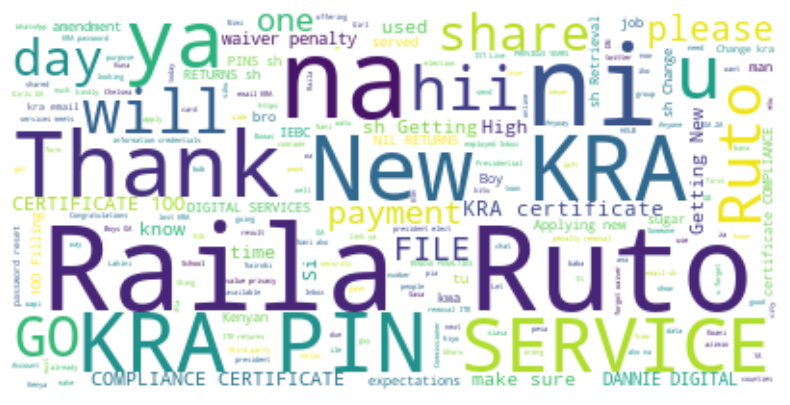

In [44]:
text = " ".join([review for review in data_clean.Message if len(review) > 2 and review != '<Media omitted>']) 
# text= [word for ]
wordcloud =WordCloud(stopwords=STOPWORDS, background_color="white").generate(text) 

### Display the generated image:
plt.figure( figsize=(10,5)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()
